In [2]:
import gjp
import statistics
import numpy as np
import pandas as pd
import iqisa as iqs

In [3]:
m=gjp.Markets()
m.load()
s=gjp.Surveys()
s.load()

/home/niplav/proj/iqisa/gjp.py:46: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  self.load_complete(files)
/usr/lib/python3/dist-packages/dateutil/parser/_parser.py:1199: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
/usr/lib/python3/dist-packages/dateutil/parser/_parser.py:1199: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
/home/niplav/proj/iqisa/gjp.py:46: DtypeWarning: Columns (6,7,9,21) have mixed types.Specify dtype option on import or set low_memory=False.
  self.load_complete(files)


In [4]:
print(m.forecasts.shape)
print(m.questions.shape)
print(s.forecasts.shape)
print(s.questions.shape)

(735432, 15)
(617, 14)
(3143460, 15)
(617, 14)


In [5]:
def brier_score(probabilities, outcomes, *args):
        return np.mean((probabilities-outcomes)**2)

trader_scores=iqs.score(m.forecasts, brier_score, on=['user_id'])
filtered_trader_scores=iqs.score(m.forecasts.groupby(['user_id']).filter(lambda x: len(x)>100), brier_score, on=['user_id'])
highly_filtered_trader_scores=iqs.score(m.forecasts.groupby(['user_id']).filter(lambda x: len(x)>1000), brier_score, on=['user_id'])

In [6]:
print(trader_scores.describe())
print(filtered_trader_scores.describe())
print(highly_filtered_trader_scores.describe())

             score
count  2404.000000
mean      0.160547
std       0.084879
min       0.000100
25%       0.116689
50%       0.150936
75%       0.186568
max       0.792100
            score
count  929.000000
mean     0.158090
std      0.053332
min      0.018641
25%      0.128133
50%      0.156140
75%      0.179822
max      0.722772
            score
count  130.000000
mean     0.148736
std      0.038856
min      0.042081
25%      0.125740
50%      0.148640
75%      0.172906
max      0.248622


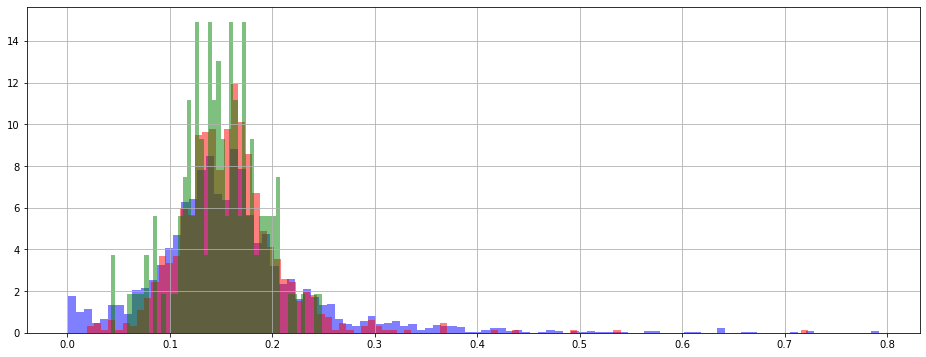

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,6))
plt.hist(trader_scores['score'], bins=100, density=True, alpha=0.5, align='mid', color='blue')
plt.hist(filtered_trader_scores['score'], bins=100, density=True, alpha=0.5, align='mid', color='red')
plt.hist(highly_filtered_trader_scores['score'], bins=50, density=True, alpha=0.5, align='mid', color='green')
plt.grid()

### Different Analyses

When wanting to know how well groups of forecasters perform, we can perform different kinds of analyses, with different kinds of aggregated parts of the dataset.

1. We score forecasters, and sort them by their score.
2. We randomly choose groups of forecasters of size $2 \le i \le n$ (for some maximal $n$) and then compute the score of those groups. On average, what percentile of forecaster performance does a group of size $i$ find itself in?
    1. We also aggregate the forecasts from those groups in a smarter way.
3. We score teams of forecasters and find out what percentile of forecaster performance each team finds themselves in.
    1. We also aggregate the forecasts from those teams in a smarter way.

In [8]:
max_group_size=100
sample_size=100
groups=[np.random.choice(np.unique(m.forecasts['user_id']), size=(sample_size, i)) for i in range(2, max_group_size)]

In [9]:
def geom_odds_aggr(forecasts):
    probabilities=forecasts['probability']
    probabilities=probabilities/(1-probabilities)
    aggregated=statistics.geometric_mean(probabilities)
    aggregated=aggregated/(1+aggregated)
    return np.array([aggregated])

In [13]:
all_group_scores=pd.DataFrame(columns=['size', 'score', 'aggregated'])
for i in range(0, max_group_size-2):
    for group in groups[i]:
        group_table=pd.DataFrame({'user_id': group})
        group_forecasts=pd.merge(m.forecasts, group_table, on=['user_id'], how='inner')
        aggregated_group_forecasts=iqs.aggregate(group_forecasts, geom_odds_aggr)
        group_scores=iqs.score(group_forecasts, brier_score)['score']
        aggregated_group_scores=iqs.score_aggregations(aggregated_group_forecasts, brier_score)['score']
        group_score=np.mean(group_scores)
        aggregated_group_score=np.mean(aggregated_group_scores)
        nf=pd.DataFrame({'size': [i+2, i+2], 'score': [group_score, aggregated_group_score], 'aggregated': [False, True]})
        all_group_scores=pd.concat([all_group_scores, nf])

In [14]:
group_scores=all_group_scores.groupby(['size', 'aggregated']).apply(lambda x: np.mean(x['score']))
group_scores=group_scores.reset_index(name='score')
group_scores['percentile']=group_scores['score'].apply(lambda x: len(np.where(trader_scores['score']>x)[0])/len(trader_scores))
group_scores

,size,aggregated,score,percentile
0,2,False,0.149872,0.490315
1,2,True,0.140819,0.553269
2,3,False,0.152160,0.479822
3,3,True,0.141190,0.550444
4,4,False,0.151558,0.482647
...,...,...,...,...
191,97,True,0.100313,0.809524
192,98,False,0.143283,0.532284
193,98,True,0.099092,0.813559
194,99,False,0.143194,0.532688


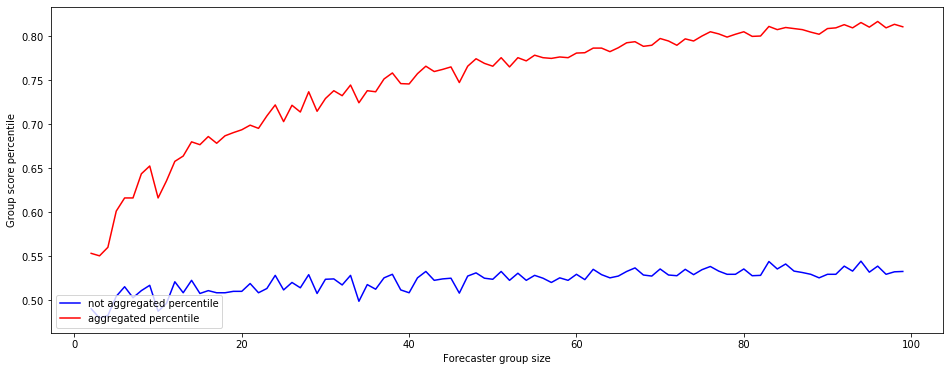

In [15]:
notaggregated=group_scores.loc[group_scores['aggregated']==False].set_index(['size'])
aggregated=group_scores.loc[group_scores['aggregated']==True].set_index(['size'])
fig=plt.figure(figsize=(16,6))
plt.xlabel('Forecaster group size')
plt.ylabel('Group score percentile')
plt.plot(notaggregated['percentile'], color='blue', label='not aggregated percentile')
plt.plot(aggregated['percentile'], color='red', label='aggregated percentile')

plt.legend(loc='lower left')